In [1]:
import torch, matplotlib as mpl
import time
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
from torch import tensor
from torch import nn
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
import coremltools as ct

scikit-learn version 1.3.0 is not supported. Minimum required version: 0.17. Maximum required version: 1.1.2. Disabling scikit-learn conversion API.


### Configure GPU acceleration

In [2]:
# cuda: NVIDIA GPUs, mps: Metal Performance Shaders (Apple M GPUs), cpu: generic CPU
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
print(device)

mps


### Import MNIST data

In [3]:
# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])

# Download and load the training data
trainset = datasets.MNIST('./MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=10000, shuffle=True)

# Download and load the test data
testset = datasets.MNIST('./MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=10000, shuffle=True)

#### Create tensors for training and testing from data

In [4]:
x_train, y_train = next(iter(trainloader))
x_test, y_test = next(iter(testloader))
x_train.shape

torch.Size([10000, 1, 28, 28])

In [5]:
x_train = x_train.view(10000,-1)
x_test = x_test.view(10000,-1)
x_train.shape

torch.Size([10000, 784])

tensor(6)


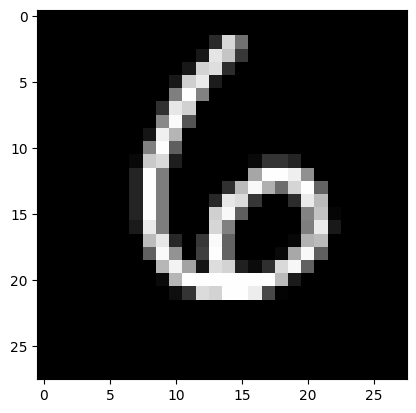

In [6]:
print(y_train[500])
xsq = x_train.reshape((-1,28,28)).to(torch.device("cpu"))
_ = plt.imshow(xsq[500].view(28,28), cmap='gray')

## Neural Network

### Configure network

In [7]:
# construct the model
nin = x_train.shape[1]
nout = int(np.max(y_train.numpy())+1)

# Create Net class
# nin: dimension of input data
# nout: number of outputs
class Net(nn.Module):
    def __init__(self,nin,nout):
        super(Net,self).__init__()
        self.sigmoid = nn.ReLU()
        self.Dense1 = nn.Linear(nin,80)
        self.Dense2 = nn.Linear(80,nout)
        self.dropout = nn.Dropout(p=0.0125)
        
    def forward(self,x):
        # layer 1
        x = self.sigmoid(self.Dense1(x))
        x = self.dropout(x)
        # layer 2
        out = self.Dense2(x)
        return out

# Initialize network
model = Net(nin=nin, nout=nout)

# Print string representation
print(str(model))

Net(
  (sigmoid): ReLU()
  (Dense1): Linear(in_features=784, out_features=80, bias=True)
  (Dense2): Linear(in_features=80, out_features=10, bias=True)
  (dropout): Dropout(p=0.0125, inplace=False)
)


In [8]:
x_train = x_train.view(10000,-1).to(device)
y_train = y_train.to(device)

train_ds = torch.utils.data.TensorDataset(x_train, y_train)

# Create a training/test data loader from datasets
train_loader = torch.utils.data.DataLoader(train_ds, batch_size=50, shuffle=True)

In [9]:
%%time

model.to(device)

lr = 1e-3
opt = optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

a_tr_loss = []
a_tr_accuracy = []

num_epoch = 100

for epoch in range(num_epoch):
    model.train() # put model in training mode
    correct = 0 # initialize error counter
    total = 0 # initialize total counter
    batch_loss_tr = []
    # iterate over training set
    for train_iter, data in enumerate(train_loader):
        x_batch, y_batch = data
        y_batch = y_batch.type(torch.long)
        out = model(x_batch)
        # Compute Loss
        loss = criterion(out, y_batch)
        batch_loss_tr.append(loss.item())
        # Compute gradients using back propagation
        opt.zero_grad()
        loss.backward()
        # Take an optimization 'step'
        opt.step()
        # Do hard classification: index of largest score
        _, predicted = torch.max(out.data, 1)
        # Compute number of decision errors
        total += y_batch.size(0)
        correct += (predicted == y_batch).sum().item()
        
    a_tr_loss.append(np.mean(batch_loss_tr)) # Compute average loss over epoch
    a_tr_accuracy.append(100*correct/total)

    if ((epoch+1) % 10 == 0) or (epoch == 0):
        print('Epoch: {0:2d}   Train Loss: {1:.3f}   '.format(epoch+1, a_tr_loss[epoch])
          +'Train Acc: {0:.2f}   '.format(a_tr_accuracy[epoch]))

Epoch:  1   Train Loss: 0.741   Train Acc: 79.17   
Epoch: 10   Train Loss: 0.154   Train Acc: 95.62   
Epoch: 20   Train Loss: 0.065   Train Acc: 98.04   
Epoch: 30   Train Loss: 0.027   Train Acc: 99.29   
Epoch: 40   Train Loss: 0.020   Train Acc: 99.42   
Epoch: 50   Train Loss: 0.014   Train Acc: 99.59   
Epoch: 60   Train Loss: 0.018   Train Acc: 99.38   
Epoch: 70   Train Loss: 0.009   Train Acc: 99.71   
Epoch: 80   Train Loss: 0.008   Train Acc: 99.72   
Epoch: 90   Train Loss: 0.011   Train Acc: 99.64   
Epoch: 100   Train Loss: 0.004   Train Acc: 99.86   
CPU times: user 47.1 s, sys: 5.5 s, total: 52.6 s
Wall time: 1min 10s


In [10]:
# compute the training accuracy
model.eval()

with torch.no_grad():
    predict = model(x_test.to(device)).cpu().detach().numpy().argmax(axis=1)
acc = np.mean(predict==y_test.numpy())
print('training accuracy: ',acc)

training accuracy:  0.956


## Export as CoreML

In [11]:
%%time

# Then, create an example input tensor
example_input = torch.rand(1, 784)  # Adjust size accordingly to your input

# Convert your model to TorchScript via tracing
traced_model = torch.jit.trace(model.cpu(), example_input)

# Now you can convert your TorchScript model to CoreML
coreml_model = ct.convert(
    traced_model,
    inputs=[ct.TensorType(name="image", shape=example_input.shape)],
    source='pytorch'
)

# Save the CoreML model
coreml_model.save('MNIST.mlpackage')

When both 'convert_to' and 'minimum_deployment_target' not specified, 'convert_to' is set to "mlprogram" and 'minimum_deployment_targer' is set to ct.target.iOS15 (which is same as ct.target.macOS12). Note: the model will not run on systems older than iOS15/macOS12/watchOS8/tvOS15. In order to make your model run on older system, please set the 'minimum_deployment_target' to iOS14/iOS13. Details please see the link: https://coremltools.readme.io/docs/unified-conversion-api#target-conversion-formats
Running MIL backend_mlprogram pipeline: 100%|███████████████████████████████████| 12/12 [00:00<00:00, 24244.53 passes/s]


CPU times: user 182 ms, sys: 41.9 ms, total: 224 ms
Wall time: 259 ms
